In [1]:
####################################################################################
#
# Weberp_Project.ipynb - script for comparing patch and schema files for Weberp project
# Copyright (C) 2023  Sravani Namburi
#
# Weberp_Project.ipynb program is free software; you can redistribute it and/or modify
# it under the terms of the GNU General Public License as published by
# the Free Software Foundation; either version 3 of the License, or
# (at your option) any later version.
# 
# Weberp_Project.ipynb program is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
# GNU General Public License for more details.
# 
# You should have received a copy of the GNU General Public License along
# with Weberp_Project.ipynb program; If not, see <https://www.gnu.org/licenses/>.
#
####################################################################################

In [2]:
import os
import io
import csv
import shutil
import git
import re
import pandas as pd
import argparse
import matplotlib.pyplot as plt
import numpy as np

### Process Patch Files

In [3]:
#!/usr/bin/env python

# Process the patch files and extract the count of DDL statements, saving the results in CSV files

#Repository clone
GITHUB_URL_Weberp = 'https://github.com/webERP-team/webERP.git'
FOLDER_PATH_Weberp = 'Datasets/Weberp/Input/Patch_Files/Git_WebERP'

def get_repo_weberp():
    if not os.path.exists(os.path.join(os.getcwd(), FOLDER_PATH_Weberp)):
        print("Weberp Repository cloning...")
        repo = git.Repo.clone_from(GITHUB_URL_Weberp, FOLDER_PATH_Weberp)
        print("Repo cloned.")
    else:
        repo = git.Repo(FOLDER_PATH_Weberp)
        print("Existing Weberp repo used.")
    return repo


#Extract version
def get_version_weberp(filename):
    return filename.strip()[:-4]


#select Sql patters 
def sql_query():
    cmp_dct = dict()
    cmp_dct["Version"] = 0
    cmp_dct["File_Path"] = 0
    cmp_dct["Create_Table"] = 0  
    cmp_dct["Drop_Table"] = 0  
    cmp_dct["Add_Column"] = 0  
    cmp_dct["Drop_Column"] = 0  
    cmp_dct["Change_Column_Datatype"] = 0 
    cmp_dct["Rename_Table"] = 0  
    cmp_dct["Rename_Column"] = 0  
    return cmp_dct

#parse the sql statements
def sql_parse_output(cmp_dct, output):
    lines = output.split("\n")

    for line in lines:
        if "CREATE TABLE" in line.upper():
            cmp_dct["Create_Table"] += 1
        
        if "DROP TABLE" in line.upper():
            if "DROP TABLE IF EXISTS" not in line:
                cmp_dct["Drop_Table"] += 1
              
        if line.find("ADD") != -1:
            if "ADD INDEX" not in line and "ADD KEY" not in line and "ADD UNIQUE" not in line \
            and "ADD PRIMARY KEY" not in line and "ADD FOREIGN KEY" not in line \
            and "ADD  FOREIGN  KEY" not in line and "ADD CONSTRAINT" not in line and "ADD  CONSTRAINT" not in line:
                cmp_dct["Add_Column"] += line.count("ADD")  
                             
        else:
            if line.find("add ") != -1:
                if "INDEX" not in line and "KEY" not in line and "UNIQUE" not in line \
                and "PRIMARY KEY" not in line and "FOREIGN KEY" not in line and "CONSTRAINT" not in line:
                    cmp_dct["Add_Column"] += 1
                    
        if "ALTER TABLE" in line and "ADD" in line and "," in line and "ADD INDEX" in line and "DROP INDEX" not in line and \
            "`," not in line:
            cmp_dct["Add_Column"] += 1
                   
        if "DROP" in line.upper().split():
            if "DROP TABLE" not in line.upper() and "DROP INDEX" not in line.upper() \
            and "DROP KEY" not in line.upper() and "DROP UNIQUE" not in line.upper() and "DROP PRIMARY KEY" not in line.upper() \
            and "DROP FOREIGN KEY" not in line.upper() and "DROP CONSTRAINT" not in line.upper() and "DROP DEFAULT" not in line.upper():
                cmp_dct["Drop_Column"] += 1
             
        if "MODIFY" in line.upper().split():
            cmp_dct["Change_Column_Datatype"] += 1
          
        if "RENAME" in line.upper().split():
            cmp_dct["Rename_Table"] += 1
          
        if line.find("CHANGE") != -1:
            if "CHANGE COLUMN" not in line:
                columns = line.replace("  ", " ").split("CHANGE ")[1].split(" ")
                col1 = columns[0].strip("`")  
                col2 = columns[1].strip("`")  
                if col1 != col2:
                    cmp_dct["Rename_Column"] += 1
                else:
                    cmp_dct["Change_Column_Datatype"] += 1
                                    
        else:
            if "change" in line.split():
                columns = line.split("change ")[1].split(" ")
                col1 = columns[0].strip("`")  
                col2 = columns[1].strip("`")  
                if col1 != col2:
                    cmp_dct["Rename_Column"] += 1
                else:
                    cmp_dct["Change_Column_Datatype"] += 1                  

        if line.find("CHANGE COLUMN")  != -1:
            columns = line.split("CHANGE COLUMN ")[1].split(" ") 
            col1 = columns[0].strip("`")  
            col2 = columns[1].strip("`")  
            if col1 != col2:
                cmp_dct["Rename_Column"] += 1
            else:
                cmp_dct["Change_Column_Datatype"] += 1   
                        
    return cmp_dct        


def list_sql(File):
    with open(File, 'r', encoding='utf8') as f:
        lines = f.readlines()
        sql_script = ' '.join([line for line in lines if not line.strip().startswith('INSERT') and \
                               not line.strip().startswith('--') and not line.strip().startswith('#') and \
                               not line.strip().startswith('##') and not line.upper().strip().startswith('INSERT') and \
                               not line.upper().strip().startswith('UPDATE') and not line.strip().startswith('VALUES') and \
                               not line.strip().startswith('(')])
        
    return sql_script

    
def Weberp():
    os.chdir("..")  
    repo = get_repo_weberp()  
    repo.git.execute(['git', 'checkout', 'master'])
    sql_files=repo.git.execute(['git', 'ls-files','''*.sql'''])
    file_paths= [os.path.join("Datasets/Weberp/Input/Patch_Files/Git_WebERP",path_string) for path_string in sql_files.split('\n')]   
    file_basenames = [os.path.basename(path_string) for path_string in file_paths]
    sql_files1 = [f for f in repo.git.ls_files().split('\n') if f.endswith('.sql')]

    # Count the number of commits that have modified each .sql file
    rows = []
    for File in sql_files1:
        try:
            commits = list(repo.iter_commits(paths=File))
            rows.append((File, File.split('/')[-1].replace('.sql',''), len(commits)))
        except Exception as e:
            print(f"Error counting commits for file {File}: {str(e)}")
    with open('{}/Datasets/Weberp/Output/Weberp_Commit_Count.csv'.format(os.getcwd()), 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(['File_Path', 'File', 'Commit_Count'])
        writer.writerows(rows)

    # log file for each SQL file
    with open("{}/Datasets/Weberp/Output/Weberp_SQLFile_log_Info.txt".format(os.getcwd()), 'w') as f:
        for file_path in sql_files.split('\n'):
            log = repo.git.log(file_path)
            f.write(f'Git log for file {file_path}:\n{log}\n\n')

    # Extract SQL schema changes   
    def schema_changes():
        results_dict = {"File_Path": [], "Version": [], "Create_Table": [], "Drop_Table": [], "Add_Column": [], "Drop_Column": [], "Change_Column_Datatype": [],"Rename_Table": [],"Rename_Column": []}
        for each_file, each_file_path in zip(file_basenames, file_paths):
            cmp_dct=sql_query()
            if not each_file.startswith("upgrade"):
                continue
                
            #we need to skip this files from patch, because DSF files start from verion 3.0 (commit history). 
            if each_file.startswith("upgrade2.7-2.8.sql"):
                continue
            if each_file.startswith("upgrade2.8-2.9.sql"):
                continue
            if each_file.startswith("upgrade2.9-2.9a.sql"):
                continue  
            if each_file.startswith("upgrade2.9a-2.9b.sql"):
                continue                
                
            version = get_version_weberp(each_file)
            cmp_dct['Version'] = version
            
            Filepath = each_file_path.strip().replace('Git_WebERP\\','')
            cmp_dct['File_Path'] = Filepath
            
            results_cmp_dct = sql_parse_output(cmp_dct,list_sql(each_file_path))
            for key,value in results_cmp_dct.items():
                results_dict[key].append(value)
               
        df = pd.DataFrame(results_dict)
        df.loc[:,'SMOs_Total'] = df.sum(numeric_only=True, axis=1)
        df.to_csv("{}/Datasets/Weberp/Output/Weberp_MySQL_Patch_Files.csv".format(os.getcwd()),index=False)
        
    schema_changes()
    os.chdir("Code") 
    
def main():
    Weberp()
                   
if __name__ == "__main__":
   main()

Existing Weberp repo used.


In [4]:
# Merge the two dataframes (patch files smos and commit count)
os.chdir('..')
Weberp_Patch = pd.read_csv('{}/Datasets/WebERP/Output/Weberp_MySQL_Patch_Files.csv'.format(os.getcwd()))
Commit_Count = pd.read_csv('{}/Datasets/WebERP/Output/Weberp_commit_count.csv'.format(os.getcwd()))
Commit_Count = Commit_Count[['File', 'Commit_Count']]

Weberp_Merged = Weberp_Patch.merge(Commit_Count, left_on='Version', right_on='File', how='left')
Weberp_Merged.drop(['File'], axis=1, inplace=True)
Weberp_Merged.to_csv('{}/Datasets/WebERP/Output/Weberp_SMOs_and_Commit_Count.csv'.format(os.getcwd()), index=False)
os.chdir('Code')

In [5]:
# Add a new column for the project name
os.chdir('..')
if 'Project_Name' not in Weberp_Merged.columns:
    Weberp_Merged.insert(0, 'Project_Name', 'webERP')

Weberp_Merged['Project_Name'] = Weberp_Merged['Project_Name'].fillna('webERP')
Weberp_Merged.to_csv('{}/Datasets/WebERP/Output/Weberp_SMOs_and_Commit_Count.csv'.format(os.getcwd()), index=False)
os.chdir('Code')

In [6]:
# Drop duplicate columns in merged dataframes
Weberp_Patch_Sum = Weberp_Merged.drop(['File_Path', 'Version'], axis=1).sum()
Weberp_df = pd.DataFrame([Weberp_Patch_Sum])
Weberp_df['Project'] = ['webERP']

Weberp_Patch_df = Weberp_df[['Project', 'Create_Table', 'Drop_Table',  'Add_Column',  'Drop_Column', 'Change_Column_Datatype',  'Rename_Table',  'Rename_Column',  'SMOs_Total', 'Commit_Count']]
print(Weberp_Patch_df)

  Project  Create_Table  Drop_Table  Add_Column  Drop_Column  \
0  webERP            92           5         187           19   

   Change_Column_Datatype  Rename_Table  Rename_Column  SMOs_Total  \
0                     162             1             15         481   

   Commit_Count  
0           405  


In [7]:
Weberp_Merged

,Project_Name,File_Path,Version,Create_Table,Drop_Table,Add_Column,Drop_Column,Change_Column_Datatype,Rename_Table,Rename_Column,SMOs_Total,Commit_Count
0,webERP,Datasets/Weberp/Input/Patch_Files/sql/mysql/up...,upgrade3.00-3.01,0,0,0,0,1,0,0,1,13
1,webERP,Datasets/Weberp/Input/Patch_Files/sql/mysql/up...,upgrade3.01-3.02,7,0,2,1,0,1,6,17,4
2,webERP,Datasets/Weberp/Input/Patch_Files/sql/mysql/up...,upgrade3.02-3.03,0,0,20,0,6,0,4,30,7
3,webERP,Datasets/Weberp/Input/Patch_Files/sql/mysql/up...,upgrade3.03-3.04,0,0,0,2,1,0,0,3,7
4,webERP,Datasets/Weberp/Input/Patch_Files/sql/mysql/up...,upgrade3.04-3.05,3,0,1,0,0,0,0,4,20
5,webERP,Datasets/Weberp/Input/Patch_Files/sql/mysql/up...,upgrade3.05-3.06,3,1,3,0,1,0,0,8,13
6,webERP,Datasets/Weberp/Input/Patch_Files/sql/mysql/up...,upgrade3.06-3.07,2,0,0,0,0,0,0,2,3
7,webERP,Datasets/Weberp/Input/Patch_Files/sql/mysql/up...,upgrade3.07-3.08,0,0,3,0,0,0,0,3,3
8,webERP,Datasets/Weberp/Input/Patch_Files/sql/mysql/up...,upgrade3.08-3.09,3,0,6,0,2,0,0,11,19
9,webERP,Datasets/Weberp/Input/Patch_Files/sql/mysql/up...,upgrade3.09-3.10,7,0,9,3,3,0,0,22,22


In [8]:
# Calculate the sum of each metric
Weberp_Patch_df = Weberp_Patch_df.drop(['Project'], axis=1).sum()
print(Weberp_Patch_df)

Create_Table               92
Drop_Table                  5
Add_Column                187
Drop_Column                19
Change_Column_Datatype    162
Rename_Table                1
Rename_Column              15
SMOs_Total                481
Commit_Count              405
dtype: int64


### Process Database Schema Files

In [9]:
# Process the database migration files, and count the DDL statements, save the output in a CSV file

os.chdir('..')
Database_MigrationFile = '{}/MySQLDiff/Output/Weberp_cmp_Schema.txt'.format(os.getcwd())
SMO_type = ["CREATE TABLE", "DROP TABLE", "RENAME", "ADD COLUMN", "DROP COLUMN", "CHANGE COLUMN", "MODIFY COLUMN"]

File_Names = []
CT_nums = []
DT_nums = []
RT_nums = []
AC_nums = []
DC_nums = []
CC_nums = []
RC_nums = []
Total_nums = []

with open(Database_MigrationFile, 'r') as File:
    File_Count = {string: 0 for string in SMO_type}
    File_Name = ""
    for line in File:
        if line.startswith("Diff between"):
            if File_Count:  
                File_Names.append(File_Name)
                CT_nums.append(File_Count['CREATE TABLE'])
                DT_nums.append(File_Count['DROP TABLE'])
                RT_nums.append(File_Count['RENAME'])
                AC_nums.append(File_Count['ADD COLUMN'])
                DC_nums.append(File_Count['DROP COLUMN'])
                CC_nums.append(File_Count['CHANGE COLUMN'])
                RC_nums.append(File_Count['MODIFY COLUMN'])
                Total_nums.append(sum(File_Count.values()))
            # Extract the file names
            File_Name = line.split(" and ")[0].strip().split(":")[0].split('/')[-1] + ' to ' + line.split(" and ")[1].strip().split(":")[0].split('/')[-1]
            File_Count = {string: 0 for string in SMO_type}
        else:
            for string in SMO_type:
                if string in line:
                    File_Count[string] += 1
        
    if File_Count:  
        File_Names.append(File_Name)
        CT_nums.append(File_Count['CREATE TABLE'])
        DT_nums.append(File_Count['DROP TABLE'])
        RT_nums.append(File_Count['RENAME'])
        AC_nums.append(File_Count['ADD COLUMN'])
        DC_nums.append(File_Count['DROP COLUMN'])
        CC_nums.append(File_Count['CHANGE COLUMN'])
        RC_nums.append(File_Count['MODIFY COLUMN'])
        Total_nums.append(sum(File_Count.values()))

Columns = {
    'File names': File_Names,
    'CT num': CT_nums,
    'DT num': DT_nums,
    'AC num': AC_nums,
    'DC num': DC_nums,
    'CC num': CC_nums,
    'RT num': RT_nums,
    'RC num': RC_nums,
    "SMO's_Total": Total_nums
}

Weberp_DMF_df = pd.DataFrame(Columns)
Weberp_DMF_df = Weberp_DMF_df.iloc[1:]
print(Weberp_DMF_df)
os.chdir('Code')

                                           File names  CT num  DT num  AC num  \
1   Weberp-3.0-demo_mod_sort.sql to Weberp-3.01-de...       0       0       0   
2   Weberp-3.01-demo_mod_sort.sql to Weberp-3.02-d...       8       1       6   
3   Weberp-3.02-demo_mod_sort.sql to Weberp-3.03-d...       0       0      21   
4   Weberp-3.03-demo_mod_sort.sql to Weberp-3.04-d...       0       0       0   
5   Weberp-3.04-demo_mod_sort.sql to Weberp-3.05-d...       3       0       1   
6   Weberp-3.05-demo_mod_sort.sql to Weberp-3.06-d...       3       1       3   
7   Weberp-3.06-demo_mod_sort.sql to Weberp-3.07-d...       2       0       0   
8   Weberp-3.07-demo_mod_sort.sql to Weberp-3.08-d...       0       0       3   
9   Weberp-3.08-demo_mod_sort.sql to Weberp-3.09-d...       3       0       6   
10  Weberp-3.09-demo_mod_sort.sql to Weberp-3.10-d...       6       0       8   
11  Weberp-3.10-demo_mod_sort.sql to Weberp-3.11-d...       6       0      31   
12  Weberp-3.11-demo_mod_sor

In [10]:
# Calculate the sum of metrics

Weberp_DMF_Sum_df = Weberp_DMF_df[['CT num', 'DT num', 'AC num', 'DC num', 'CC num', 'RT num', 'RC num',"SMO's_Total"]].sum()
print("Sum of Database Schema Files Metrics:")
print(Weberp_DMF_Sum_df)

Sum of Database Schema Files Metrics:
CT num          85
DT num           2
AC num         201
DC num          38
CC num         153
RT num           0
RC num           0
SMO's_Total    479
dtype: int64


In [11]:
print(Weberp_DMF_Sum_df)
print(Weberp_Patch_df)

CT num          85
DT num           2
AC num         201
DC num          38
CC num         153
RT num           0
RC num           0
SMO's_Total    479
dtype: int64
Create_Table               92
Drop_Table                  5
Add_Column                187
Drop_Column                19
Change_Column_Datatype    162
Rename_Table                1
Rename_Column              15
SMOs_Total                481
Commit_Count              405
dtype: int64


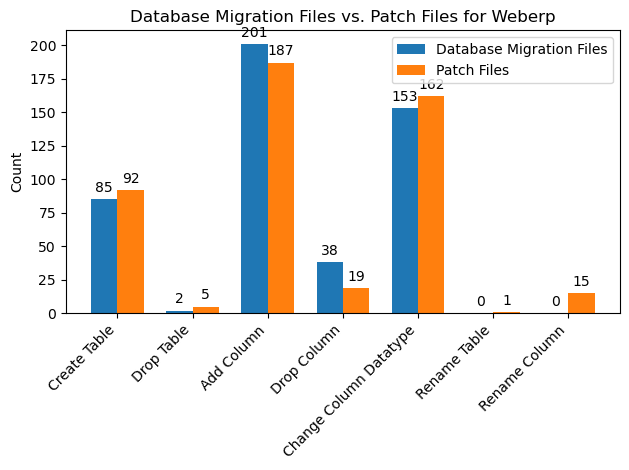

In [12]:
#Plot of Patch files and Database Migration files SMOs in the dataset

Weberp_DMF_columns = ['CT num', 'DT num', 'AC num', 'DC num', 'CC num', 'RT num', 'RC num']
Weberp_DMF_values = Weberp_DMF_Sum_df.loc[Weberp_DMF_columns].values

Weberp_Patch_columns = ['Create_Table', 'Drop_Table', 'Add_Column', 'Drop_Column', 'Change_Column_Datatype', 'Rename_Table', 'Rename_Column']
Weberp_Patch_values =  Weberp_Patch_df.loc[Weberp_Patch_columns].values


bar_width = 0.35
index = np.arange(len(Weberp_DMF_values))
labels = ['Create Table', 'Drop Table', 'Add Column', 'Drop Column',
          'Change Column Datatype', 'Rename Table', 'Rename Column']
fig, ax = plt.subplots()
rects1 = ax.bar(index, Weberp_DMF_values, bar_width, label='Database Migration Files')
rects2 = ax.bar(index + bar_width, Weberp_Patch_values, bar_width, label='Patch Files')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(labels, rotation=45, ha='right')
ax.set_ylabel('Count')
ax.set_title('Database Migration Files vs. Patch Files for Weberp')
ax.legend()

for rect in rects1 + rects2:
    height = rect.get_height()
    ax.annotate('{}'.format(height),
                xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, 3),  
                textcoords="offset points",
                ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [13]:
# Absolute difference and relative difference

Absolute_Difference = Weberp_Patch_df['SMOs_Total'] - Weberp_DMF_Sum_df["SMO's_Total"]
Relative_Difference = (Weberp_Patch_df['SMOs_Total'] - Weberp_DMF_Sum_df["SMO's_Total"]) / ((Weberp_Patch_df['SMOs_Total'] + Weberp_DMF_Sum_df["SMO's_Total"])/2) * 100

print("Absolute Difference:", Absolute_Difference)
print("Relative Difference:", round(Relative_Difference, 2), "%")
print("Matching percent for Patch Files and Database Migration Files:", round(100 - round(abs(float(Relative_Difference)), 2), 2) ,"%")

Absolute Difference: 2
Relative Difference: 0.42 %
Matching percent for Patch Files and Database Migration Files: 99.58 %


In [14]:
#Absolute values and percent values

Weberp_Patch_Percent_df = Weberp_Patch_df

pattern = Weberp_Patch_Percent_df['Create_Table']  
Weberp_Patch_Percent_df['Percent_create'] = round((pattern / Weberp_Patch_Percent_df['SMOs_Total']) * 100,1)

pattern = Weberp_Patch_Percent_df['Drop_Table']  
Weberp_Patch_Percent_df['Percent_drop'] = round((pattern / Weberp_Patch_Percent_df['SMOs_Total']) * 100,1)

pattern = Weberp_Patch_Percent_df['Add_Column']  
Weberp_Patch_Percent_df['Percent_add'] = round((pattern / Weberp_Patch_Percent_df['SMOs_Total']) * 100,1)

pattern = Weberp_Patch_Percent_df['Drop_Column']  
Weberp_Patch_Percent_df['Percent_dc'] = round((pattern / Weberp_Patch_Percent_df['SMOs_Total']) * 100,1)

pattern = Weberp_Patch_Percent_df['Change_Column_Datatype']  
Weberp_Patch_Percent_df['Percent_ccd'] = round((pattern / Weberp_Patch_Percent_df['SMOs_Total']) * 100,1)

pattern = Weberp_Patch_Percent_df['Rename_Table']  
Weberp_Patch_Percent_df['Percent_rt'] = round((pattern / Weberp_Patch_Percent_df['SMOs_Total']) * 100,1)

pattern = Weberp_Patch_Percent_df['Rename_Column']  
Weberp_Patch_Percent_df['Percent_rc'] = round((pattern / Weberp_Patch_Percent_df['SMOs_Total']) * 100,1)

print(Weberp_Patch_Percent_df)

Create_Table               92.0
Drop_Table                  5.0
Add_Column                187.0
Drop_Column                19.0
Change_Column_Datatype    162.0
Rename_Table                1.0
Rename_Column              15.0
SMOs_Total                481.0
Commit_Count              405.0
Percent_create             19.1
Percent_drop                1.0
Percent_add                38.9
Percent_dc                  4.0
Percent_ccd                33.7
Percent_rt                  0.2
Percent_rc                  3.1
dtype: float64


In [15]:
# Compare CREATE table SMOs between patch files and database migration files.

Weberp_Patch_Create_Table = Weberp_Merged[['Version', 'Rename_Table', 'Create_Table']]
Weberp_DMF_CT = Weberp_DMF_df['CT num'].reset_index(drop=True)

Create_Table = pd.concat([Weberp_Patch_Create_Table, Weberp_DMF_CT], axis=1)
Create_Table['difference'] = Create_Table['Rename_Table'] + Create_Table['Create_Table'] - Create_Table['CT num']

def diff_val(row):
    color = 'lightcoral' if row['difference'] > 0 else 'lightblue' if row['difference'] < 0 else ''
    return [f'background-color: {color}' for _ in row]

Create_Table = Create_Table.style.apply(diff_val, axis=1)
Create_Table

,Version,Rename_Table,Create_Table,CT num,difference
0,upgrade3.00-3.01,0,0,0,0
1,upgrade3.01-3.02,1,7,8,0
2,upgrade3.02-3.03,0,0,0,0
3,upgrade3.03-3.04,0,0,0,0
4,upgrade3.04-3.05,0,3,3,0
5,upgrade3.05-3.06,0,3,3,0
6,upgrade3.06-3.07,0,2,2,0
7,upgrade3.07-3.08,0,0,0,0
8,upgrade3.08-3.09,0,3,3,0
9,upgrade3.09-3.10,0,7,6,1


In [16]:
# Compare DROP table SMOs between patch files and database migration files.

Weberp_Patch_Drop_Table = Weberp_Merged[['Version', 'Rename_Table', 'Drop_Table']]
Weberp_DMF_DT = Weberp_DMF_df['DT num'].reset_index(drop=True)

Drop_Table = pd.concat([Weberp_Patch_Drop_Table, Weberp_DMF_DT], axis=1)
Drop_Table['difference'] = Drop_Table['Rename_Table'] + Drop_Table['Drop_Table'] - Drop_Table['DT num']

def diff_val(row):
    color = 'lightcoral' if row['difference'] > 0 else 'lightblue' if row['difference'] < 0 else ''
    return [f'background-color: {color}' for _ in row]

Drop_Table = Drop_Table.style.apply(diff_val, axis=1)
Drop_Table

,Version,Rename_Table,Drop_Table,DT num,difference
0,upgrade3.00-3.01,0,0,0,0
1,upgrade3.01-3.02,1,0,1,0
2,upgrade3.02-3.03,0,0,0,0
3,upgrade3.03-3.04,0,0,0,0
4,upgrade3.04-3.05,0,0,0,0
5,upgrade3.05-3.06,0,1,1,0
6,upgrade3.06-3.07,0,0,0,0
7,upgrade3.07-3.08,0,0,0,0
8,upgrade3.08-3.09,0,0,0,0
9,upgrade3.09-3.10,0,0,0,0


In [17]:
# Compare ADD column SMOs between patch files and database migration files.

Weberp_Patch_Add_Column = Weberp_Merged[['Version', 'Rename_Column', 'Add_Column']]
Weberp_DMF_AC = Weberp_DMF_df['AC num'].reset_index(drop=True)

Add_Column = pd.concat([Weberp_Patch_Add_Column, Weberp_DMF_AC], axis=1)
Add_Column['difference'] = Add_Column['Rename_Column'] + Add_Column['Add_Column'] - Add_Column['AC num']

def diff_val(row):
    color = 'lightcoral' if row['difference'] > 0 else 'lightblue' if row['difference'] < 0 else ''
    return [f'background-color: {color}' for _ in row]

Add_Column = Add_Column.style.apply(diff_val, axis=1)
Add_Column

,Version,Rename_Column,Add_Column,AC num,difference
0,upgrade3.00-3.01,0,0,0,0
1,upgrade3.01-3.02,6,2,6,2
2,upgrade3.02-3.03,4,20,21,3
3,upgrade3.03-3.04,0,0,0,0
4,upgrade3.04-3.05,0,1,1,0
5,upgrade3.05-3.06,0,3,3,0
6,upgrade3.06-3.07,0,0,0,0
7,upgrade3.07-3.08,0,3,3,0
8,upgrade3.08-3.09,0,6,6,0
9,upgrade3.09-3.10,0,9,8,1


In [18]:
# Compare DROP column SMOs between patch files and database migration files.

Weberp_Patch_Drop_Column = Weberp_Merged[['Version', 'Rename_Column', 'Drop_Column']]
Weberp_DMF_DC = Weberp_DMF_df['DC num'].reset_index(drop=True)

Drop_Column = pd.concat([Weberp_Patch_Drop_Column, Weberp_DMF_DC], axis=1)
Drop_Column['difference'] = Drop_Column['Rename_Column'] + Drop_Column['Drop_Column'] - Drop_Column['DC num']

def diff_val(row):
    color = 'lightcoral' if row['difference'] > 0 else 'lightblue' if row['difference'] < 0 else ''
    return [f'background-color: {color}' for _ in row]

Drop_Column = Drop_Column.style.apply(diff_val, axis=1)
Drop_Column

,Version,Rename_Column,Drop_Column,DC num,difference
0,upgrade3.00-3.01,0,0,0,0
1,upgrade3.01-3.02,6,1,5,2
2,upgrade3.02-3.03,4,0,1,3
3,upgrade3.03-3.04,0,2,0,2
4,upgrade3.04-3.05,0,0,0,0
5,upgrade3.05-3.06,0,0,0,0
6,upgrade3.06-3.07,0,0,0,0
7,upgrade3.07-3.08,0,0,0,0
8,upgrade3.08-3.09,0,0,0,0
9,upgrade3.09-3.10,0,3,0,3


In [19]:
# Compare CHANGE COLUMN DATATYPE SMOs between patch files and database migration files.

Weberp_Patch_Change_Column_Datatype = Weberp_Merged[['Version', 'Change_Column_Datatype']]
Weberp_DMF_CC = Weberp_DMF_df['CC num'].reset_index(drop=True)

Change_Column_Datatypes = pd.concat([Weberp_Patch_Change_Column_Datatype, Weberp_DMF_CC], axis=1)
Change_Column_Datatypes['difference'] =  Change_Column_Datatypes['Change_Column_Datatype'] - Change_Column_Datatypes['CC num']

def diff_val(row):
    color = 'lightcoral' if row['difference'] > 0 else 'lightblue' if row['difference'] < 0 else ''
    return [f'background-color: {color}' for _ in row]

Change_Column_Datatypes = Change_Column_Datatypes.style.apply(diff_val, axis=1)
Change_Column_Datatypes

,Version,Change_Column_Datatype,CC num,difference
0,upgrade3.00-3.01,1,1,0
1,upgrade3.01-3.02,0,0,0
2,upgrade3.02-3.03,6,9,-3
3,upgrade3.03-3.04,1,1,0
4,upgrade3.04-3.05,0,0,0
5,upgrade3.05-3.06,1,0,1
6,upgrade3.06-3.07,0,0,0
7,upgrade3.07-3.08,0,0,0
8,upgrade3.08-3.09,2,2,0
9,upgrade3.09-3.10,3,3,0


In [20]:
# Calculate SMOs total for patch files

Weberp_Patch_SMO = Weberp_Merged[['Version', 'SMOs_Total', 'Rename_Column', 'Rename_Table']].copy()
Weberp_Patch_SMO['SMOs_Total_RTC'] = Weberp_Patch_SMO['SMOs_Total'] + Weberp_Patch_SMO['Rename_Column'] + Weberp_Patch_SMO['Rename_Table']
print(Weberp_Patch_SMO[['Version', 'SMOs_Total_RTC']])

                 Version  SMOs_Total_RTC
0       upgrade3.00-3.01               1
1       upgrade3.01-3.02              24
2       upgrade3.02-3.03              34
3       upgrade3.03-3.04               3
4       upgrade3.04-3.05               4
5       upgrade3.05-3.06               8
6       upgrade3.06-3.07               2
7       upgrade3.07-3.08               3
8       upgrade3.08-3.09              11
9       upgrade3.09-3.10              22
10      upgrade3.10-3.11              46
11    upgrade3.11-3.11.1               0
12    upgrade3.11.1-4.00              93
13      upgrade4.03-4.04               0
14    upgrade4.04-4.04.1               2
15  upgrade4.04.1-4.04.4               1
16  upgrade4.04.4-4.04.5               1
17    upgrade4.04.5-4.05               0
18      upgrade4.05-4.06               3
19      upgrade4.06-4.07               4
20      upgrade4.07-4.08              29
21      upgrade4.08-4.09               8
22      upgrade4.09-4.10              10
23      upgrade4

In [21]:
# Compare total SMOs between patch files and database migration files.

weberp_Patch_SMO = Weberp_Patch_SMO[['Version', 'SMOs_Total_RTC']]
Weberp_DMF_SMO = Weberp_DMF_df["SMO's_Total"].reset_index(drop=True)

Weberp_SMO_Merge = pd.concat([weberp_Patch_SMO, Weberp_DMF_SMO], axis=1)
Weberp_SMO_Merge_diff = pd.concat([weberp_Patch_SMO, Weberp_DMF_SMO], axis=1)
Weberp_SMO_Merge_diff['difference'] =  Weberp_SMO_Merge_diff['SMOs_Total_RTC'] - Weberp_SMO_Merge_diff["SMO's_Total"]

def diff_val(row):
    color = 'lightcoral' if row['difference'] > 0 else 'lightblue' if row['difference'] < 0 else ''
    return [f'background-color: {color}' for _ in row]

Weberp_SMO_Merge_diff = Weberp_SMO_Merge_diff.style.apply(diff_val, axis=1)
Weberp_SMO_Merge_diff

,Version,SMOs_Total_RTC,SMO's_Total,difference
0,upgrade3.00-3.01,1,1,0
1,upgrade3.01-3.02,24,20,4
2,upgrade3.02-3.03,34,31,3
3,upgrade3.03-3.04,3,1,2
4,upgrade3.04-3.05,4,4,0
5,upgrade3.05-3.06,8,7,1
6,upgrade3.06-3.07,2,2,0
7,upgrade3.07-3.08,3,3,0
8,upgrade3.08-3.09,11,11,0
9,upgrade3.09-3.10,22,17,5


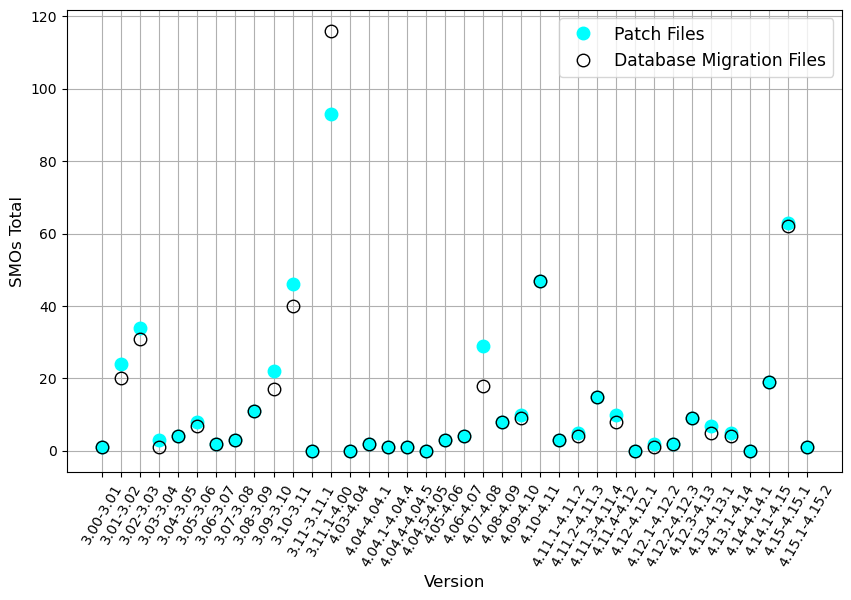

In [22]:
# Plot of Patch files and Database Migration files each version in the dataset

Weberp_Version = Weberp_Patch_SMO['Version'].str.replace('upgrade', '')  
Weberp_SMOs_Total = Weberp_Patch_SMO['SMOs_Total_RTC']

plt.figure(figsize=(10, 6))  
plt.plot(Weberp_Version, Weberp_SMOs_Total, marker='o', color='#00FFFF', label='Patch Files', linestyle='', markersize=9)
DMF_index = Weberp_DMF_SMO.index
DMF_smos_total = Weberp_DMF_SMO.values
plt.plot(DMF_index, DMF_smos_total, marker='o', color='black', label="Database Migration Files", linestyle='', markersize=9, markerfacecolor='none', markeredgecolor='black')
plt.xlabel('Version', fontsize=12)
plt.ylabel("SMOs Total", fontsize=12)
plt.xticks(rotation=60)
plt.grid(True)
plt.legend(fontsize=12.4)

plt.show()

In [23]:
# Concatenate the two DataFrames, Extract the required columns for the table level and column level.

Weberp_Patch_df = Weberp_Merged[['Version', 'Create_Table', 'Drop_Table', 'Add_Column', 'Drop_Column', 'Change_Column_Datatype', 'Rename_Table', 'Rename_Column', "SMOs_Total"]]
Weberp_DMF_df = Weberp_DMF_df[['CT num', 'DT num', 'AC num', 'DC num', 'CC num', 'RT num', 'RC num']].reset_index(drop=True)

Weberp_Patch_DMF_df = pd.concat([Weberp_Patch_df, Weberp_DMF_df], axis=1)
Weberp_Table_df = Weberp_Patch_DMF_df[['Version', 'Create_Table', 'Rename_Table', 'CT num','Drop_Table','Rename_Table','DT num']]
Weberp_Column_df= Weberp_Patch_DMF_df[['Version', 'Add_Column', 'Rename_Column','AC num', 'Drop_Column', 'Rename_Column','DC num', 'Change_Column_Datatype', 'CC num']]

In [24]:
# Table level smos
Weberp_Table_df

,Version,Create_Table,Rename_Table,CT num,Drop_Table,Rename_Table,DT num
0,upgrade3.00-3.01,0,0,0,0,0,0
1,upgrade3.01-3.02,7,1,8,0,1,1
2,upgrade3.02-3.03,0,0,0,0,0,0
3,upgrade3.03-3.04,0,0,0,0,0,0
4,upgrade3.04-3.05,3,0,3,0,0,0
5,upgrade3.05-3.06,3,0,3,1,0,1
6,upgrade3.06-3.07,2,0,2,0,0,0
7,upgrade3.07-3.08,0,0,0,0,0,0
8,upgrade3.08-3.09,3,0,3,0,0,0
9,upgrade3.09-3.10,7,0,6,0,0,0


In [25]:
# Column level smos
Weberp_Column_df

,Version,Add_Column,Rename_Column,AC num,Drop_Column,Rename_Column,DC num,Change_Column_Datatype,CC num
0,upgrade3.00-3.01,0,0,0,0,0,0,1,1
1,upgrade3.01-3.02,2,6,6,1,6,5,0,0
2,upgrade3.02-3.03,20,4,21,0,4,1,6,9
3,upgrade3.03-3.04,0,0,0,2,0,0,1,1
4,upgrade3.04-3.05,1,0,1,0,0,0,0,0
5,upgrade3.05-3.06,3,0,3,0,0,0,1,0
6,upgrade3.06-3.07,0,0,0,0,0,0,0,0
7,upgrade3.07-3.08,3,0,3,0,0,0,0,0
8,upgrade3.08-3.09,6,0,6,0,0,0,2,2
9,upgrade3.09-3.10,9,0,8,3,0,0,3,3


In [26]:
# Extract table count and table names from database migration files.

os.chdir('..')
MigrationFiles_Path = "{}/Datasets/Weberp/Input/Migration_Files".format(os.getcwd())

File_Names = []
Table_Counts = []
Table_Names = []

for Filename in os.listdir(MigrationFiles_Path):
    if Filename.endswith('.sql'):
        File_Path = os.path.join(MigrationFiles_Path, Filename)

        with open(File_Path, 'r') as File:
            Content = File.read()
            
        DDL_Statements = Content.split(';')
        Count = 0
        Names = []

        for Statement in DDL_Statements:
            if 'CREATE TABLE' in Statement:
                Table_Name = Statement.split('CREATE TABLE')[1].split('(')[0].strip()
                Names.append(Table_Name)
                Count += 1

        File_Names.append(Filename)
        Table_Counts.append(Count)
        Table_Names.append(Names)

Column_Names = {'file name': File_Names, 'table_count': Table_Counts, 'table_names': Table_Names}
Weberp_Table_list_df = pd.DataFrame(Column_Names)
print(Weberp_Table_list_df)

Weberp_Table_list = "{}/Datasets/WebERP/Output/Weberp_Databseschemafiles_table_list.csv".format(os.getcwd())
Weberp_Table_list_df.to_csv(Weberp_Table_list, index=False)
print("Weberp Table List saved to: {}".format(Weberp_Table_list))
os.chdir('Code')

                          file name  table_count  \
0      Weberp-3.0-demo_mod_sort.sql           78   
1     Weberp-3.01-demo_mod_sort.sql           78   
2     Weberp-3.02-demo_mod_sort.sql           85   
3     Weberp-3.03-demo_mod_sort.sql           85   
4     Weberp-3.04-demo_mod_sort.sql           85   
5     Weberp-3.05-demo_mod_sort.sql           88   
6     Weberp-3.06-demo_mod_sort.sql           90   
7     Weberp-3.07-demo_mod_sort.sql           92   
8     Weberp-3.08-demo_mod_sort.sql           92   
9     Weberp-3.09-demo_mod_sort.sql           95   
10    Weberp-3.10-demo_mod_sort.sql          101   
11    Weberp-3.11-demo_mod_sort.sql          107   
12  Weberp-3.11.1-demo_mod_sort.sql          107   
13    Weberp-4.00-demo_mod_sort.sql          122   
14    Weberp-4.04-demo_mod_sort.sql          122   
15  Weberp-4.04.1-demo_mod_sort.sql          122   
16  Weberp-4.04.4-demo_mod_sort.sql          122   
17  Weberp-4.04.5-demo_mod_sort.sql          122   
18    Weberp

In [27]:
# Calculate the total number of tables increased in Weberp
Weberp_Total_Tables_Increased =  Weberp_Table_list_df.iloc[-1]['table_count'] - Weberp_Table_list_df.iloc[0]['table_count']
print("Total number of tables increased in Weberp: {}".format(Weberp_Total_Tables_Increased))

Total number of tables increased in Weberp: 83


In [28]:
# Extract DDL statements include both 'ADD COLUMN' and 'ADD INDEX'.

os.chdir('..')
PatchFiles_Path = "{}/Datasets/Weberp/Input/Patch_Files/Git_WebERP/sql/mysql/".format(os.getcwd())

for Filename in os.listdir(PatchFiles_Path):
    if Filename.endswith(".sql"):
        PatchFiles = os.path.join(PatchFiles_Path, Filename)

        with open(PatchFiles, 'r') as File:
            lines = File.readlines()

        # Extract lines with "ALTER TABLE" and both "ADD" and "ADD INDEX" statements
        Add_AddIndex_Lines = [
            line.strip()
            for line in lines
            if "ALTER TABLE" in line and "ADD" in line and "," in line and "ADD INDEX" in line and "DROP INDEX" not in line and \
            "`," not in line
        ]

        for line in Add_AddIndex_Lines:
            print(f"File: {Filename}, Line: {line}")
os.chdir('Code')

File: upgrade4.09-4.10.sql, Line: ALTER TABLE `salesorders` ADD `salesperson` VARCHAR( 4 ) NOT NULL , ADD INDEX ( `salesperson` );
File: upgrade4.09-4.10.sql, Line: ALTER TABLE `locstock` ADD `bin` VARCHAR( 10 ) NOT NULL , ADD INDEX ( `bin` );
File: upgrade4.10-4.11.sql, Line: ALTER TABLE `debtortrans` ADD `salesperson` VARCHAR( 4 ) NOT NULL DEFAULT '' , ADD INDEX ( `salesperson` );
File: upgrade4.11.3-4.11.4.sql, Line: ALTER TABLE  `stockmoves` ADD  `userid` VARCHAR( 20 ) NOT NULL , ADD INDEX (  `userid` ) ;
File: upgrade4.14.1-4.15.sql, Line: ALTER TABLE `stockserialitems` ADD `createdate` timestamp NULL DEFAULT CURRENT_TIMESTAMP, ADD INDEX (`createdate`);
